In [1]:
import pandas as pd
from textblob import TextBlob
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import classification_report
nltk.download('stopwords')
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/nicolepham-
[nltk_data]     nguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nicolepham-
[nltk_data]     nguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Random Forest Classifier

In [2]:
# READ IN DATA (Choose data with profile field or without)
model_data_raw = pd.read_csv('fj.csv', index_col = 0)
#model_data_raw = pd.read_csv('fj_no_profile.csv')

# creating copy so original can still be accessed
model_data = model_data_raw.copy()

# droping unstructured columns
model_data.drop(['job_id','title','salary_range','description','requirements','benefits','posting'], axis = 1, inplace = True)

# one-hot encoding categorical variables
categorical_cols = ['location', 'department', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'company_profile'] 
model_data = pd.get_dummies(model_data, columns = categorical_cols)

# splitting data into train and test
X = model_data.drop('fraudulent', axis = 'columns')
y = model_data['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.20,
                                                    random_state = 420)

In [3]:
indices = model_data_raw.groupby("company_profile").apply(lambda x: [i for i in x.index])
indices_tf = y[[i[0]for i in indices]]
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(indices, stratify = indices_tf, test_size=0.20, random_state = 422)
# Collapsing arrays
import numpy as np
train_idx = np.hstack(train_idx.apply(np.array).values)
test_idx = np.hstack(test_idx.apply(np.array).values)
X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [4]:
from sklearn.ensemble import RandomForestClassifier
#rf_classifier = RandomForestClassifier()
classifier = RandomForestClassifier(random_state = 420)
smt = SMOTE(random_state=420)

# defining the pipeline
pipeline = Pipeline(steps = [['smote', smt],['classifier', classifier]])

In [5]:
# fitting the pipeline and printing results
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2976
           1       0.67      0.37      0.47        76

    accuracy                           0.98      3052
   macro avg       0.83      0.68      0.73      3052
weighted avg       0.98      0.98      0.98      3052



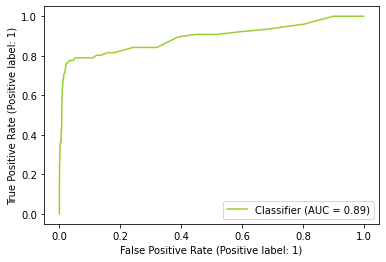

In [8]:
# ROC Curve
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_pred_proba[:,1], color='yellowgreen')

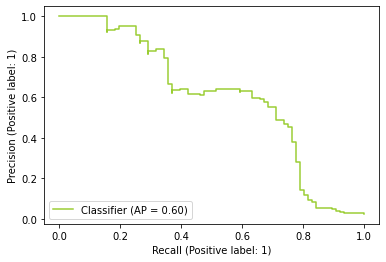

In [9]:
# Precision vs Recall Curve
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba[:,1], color='yellowgreen')

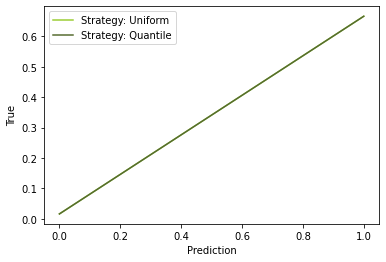

In [8]:
# Calibration Curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Strategy Uniform
prob_true1, prob_pred1 = calibration_curve(y_test, y_hat, strategy = 'uniform')

# Strategy Quantile
prob_true2, prob_pred2 = calibration_curve(y_test, y_hat, strategy = 'quantile')

plt.plot(prob_pred1, prob_true1, label='Strategy: Uniform', color='yellowgreen')
plt.plot(prob_pred2, prob_true2, label='Strategy: Quantile', color='darkolivegreen')
plt.ylabel('True')
plt.xlabel('Prediction')
plt.legend(loc='best')
plt.show()

In [9]:
feature_importance = classifier.feature_importances_
feature_importance

array([3.44459114e-03, 1.15963844e-01, 5.69773661e-02, ...,
       0.00000000e+00, 2.92269225e-06, 0.00000000e+00])

In [10]:
sorted_indices = np.argsort(feature_importance)[::-1] 
feat_labels = X.columns[1:]
 
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            feature_importance[sorted_indices[f]]))

 1) has_questions                  0.115964
 2) NAN Columns                    0.056977
 3) location_AE, ,                 0.051183
 4) word_count                     0.049005
 5) stopword_count                 0.042787
 6) description_na                 0.036462
 7) required_education_Certification 0.029525
 8) required_experience_Not Applicable 0.029112
 9) company_profile_MISSION:GoldLeaf HomeCare is revolutionizing home care by making our CarePartners top priority. GoldLeaf fully loves,honors and serves its CarePartners so they will offer the same to every Client. Placing People before profit is our guiding commitment that allows GoldLeaf to foster greater individual independences and the optimal quality of life for our Clients.This is our mission at GoldLeaf HomeCare. We are a very different medical and non-medical home health company - we pray together, we care for each other both professionally &amp; personally. Don't take our word for it, ask our team of CarePartners! GoldLeaf 

913) department_Integration & Testing 0.000031
914) industry_Public Policy         0.000031
915) location_US, VA, Blacksburg    0.000031
916) location_AU, NSW, Darlinghurst 0.000030
917) department_Auto Sales          0.000030
918) location_PH, 00, Philippies    0.000030
919) location_GB, SWD, Swindon      0.000030
920) industry_Nanotechnology        0.000030
921) company_profile_The Technical Team and offering at VML London has a very strong heritage dating back to the mid-nineties when the London office was founded. Back in those days we were one of the first few purely digital marketing agencies in London; and back then things were a lot more technically driven than they often are today; as such the Technology team here continues to enjoy a strong strategic influence on the work that the agency undertakes and the clients that we engage.It just works.Technology is brilliant when you don’t have to think about it. That’s what we strive for in our solutions. Our technology team has a st

2912) location_HU, , Budapest        0.000005
2913) company_profile_SLV is a graduate led volunteer organisation in Sri Lanka. SLV provides degree-specific volunteer placements in Sri Lanka. Our placements abroad offer people the chance to gain work experience in teaching English, coaching sports, working with children and with people with special needs, and working in the mental health sector. 0.000005
2914) department_Operations          0.000005
2915) company_profile_Anthony Warren is a Marketing and Advertising consultant.  After completing one enlistment as a U.S. Marine at Quantico, VA, where he provided administrative support to the Lawyer for the Commandant of the Marine Corps, he has hired and trained over 1000 sales people managers and CEO's to increase their effectiveness and monetize thier efforts.  His early skill as a door to door salesman has evolved from concert promoter, Real estate investor, Fundraiser and now with the internet to a supply and demand tour guide. His z

3412) company_profile_Built from the ground up to help customers improve clinical, financial and human outcomes, Wellcentive’s population health management technology is cloud-based, scalable, and customized to meet the needs of providers, health organizations and payers. Wellcentive’s technology, insight and services help care teams measure and report performance and implement actionable workflow to drive value-based reimbursement and the transition from volume to value. Wellcentive has gained recognition as a leader in population health management in reports recently released by IDC Health, KLAS and Chilmark. Wellcentive aggregates data from more than 3,000 interfaces, and its solutions improve outcomes for over 23 million lives.  0.000003
3413) location_US, DC, Washington, DC 0.000003
3414) company_profile_Shyp is the easiest way to send anything, anywhere.Here at Shyp, we’re building the #1 brand consumers and small businesses trust for shipping their packages, and in the process f

5911) location_US, PA, Waynesburg    0.000000
5912) location_US, AK, College       0.000000
5913) location_US, IL, Glendale heights 0.000000
5914) location_US, , Western US      0.000000
5915) company_profile_Tutor Doctor Carrollton consists of passionate tutors that would like to make a difference in children's education.  We make house calls to where the student's live.  Every student gets individual #URL_9cdbf78447426b302a5104aa9f44c350e7148c53f7ee894592dfd87ea6f77e90# can help students in the north Dallas, Addison, Lewisville, Carrollton areas. 0.000000
5916) company_profile_Inception Recruitment is an independent recruitment agency, run by a team of dedicated experienced recruiters.We specialise in Health and Social Care and Admin positions.CALL #PHONE_fd851744e56f60b177f6f961de59200f3c61e76340a99040649a7dba65575e95# 0.000000
5917) company_profile_Traffic Safety Systems, Innovation &amp; PartnershipInnovation around traffic safety systems has been a hallmark of REDFLEX for over qu

6284) company_profile_Somos uma empresa de TI foda! 0.000000
6285) company_profile_Handi Ramp, founded in 1958, is the oldest manufacturer of metal ramps in the United #URL_88003d34655ed7f8d4d1e5bacc716f0659f836dc0574b5dd58e9139b79fb5fe0# specialize in products within the wheelchair accessibility, material handling and non slip floor safety arenas, but love the challenge of creating solutions for any need. Our national sales team work closely with customers to create customize ramp solutions for a variety of industrial, commercial, institutional and residential markets. Successful sales members are able to develop solutions using a large array of off-the-shelf and custom products. 0.000000
6286) location_US, TX, Austin        0.000000
6287) location_US, TX, Baton Rouge   0.000000
6288) company_profile_WANT TO RUN A SUCCESSFUL FOOTBALL COACHING BUSINESS BUT NEED EXPERT KNOWLEDGE, BACKUP AND SUPPORT?WHY NOT BECOME AN OFFICIAL LICENSED ‘PRE ACADEMY’ COACH?Benefits:SIMPLE to set up.Operate

IndexError: index 6363 is out of bounds for axis 0 with size 6363